# ДЗ №4 Гладышев В.В.

## Задание № 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
import os

In [78]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

In [79]:
data_w = data.resample('W').mean()

In [80]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PJME_MW          866 non-null    float64
 1   year             866 non-null    float64
 2   month            866 non-null    float64
 3   dayofmonth       866 non-null    float64
 4   quarter          866 non-null    float64
 5   dayofyear        866 non-null    float64
 6   weekofyear       866 non-null    float64
 7   dayofweek        866 non-null    float64
 8   hour             866 non-null    float64
 9   is_holiday       866 non-null    float64
 10  is_prev_holiday  866 non-null    float64
 11  is_next_holiday  866 non-null    float64
dtypes: float64(12)
memory usage: 88.0 KB


## Задание № 2

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [30]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [31]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения
N1 = 0 #300   # берем дданные не от начала - так быстрее работает
N2 = 4  # число точек для теста

mod_w = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[N1:-N2],
                                  order=[0,0,1],
                                  seasonal_order=[0,1,2,52],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_opt_w = mod_w.fit()
print('AIC:{}',results_opt_w.aic)

AIC:{} 12951.14304129468


In [32]:
print(results_opt_w.summary().tables[0], "\n", results_opt_w.summary().tables[1])

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  862
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 52)   Log Likelihood               -6471.572
Date:                                 Mon, 15 Jun 2020   AIC                          12951.143
Time:                                         19:02:13   BIC                          12969.370
Sample:                                              0   HQIC                         12958.187
                                                 - 862                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3597      0.031     11.650      0.000       0.299       0

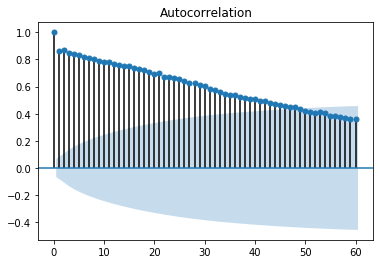

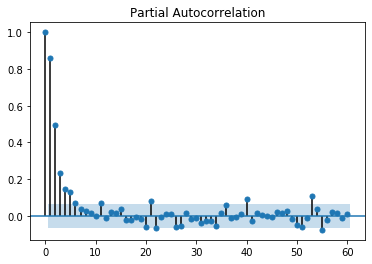

In [33]:
sm.graphics.tsa.plot_acf(results_opt_w.resid, lags=60)
sm.graphics.tsa.plot_pacf(results_opt_w.resid, lags=60)
plt.show()

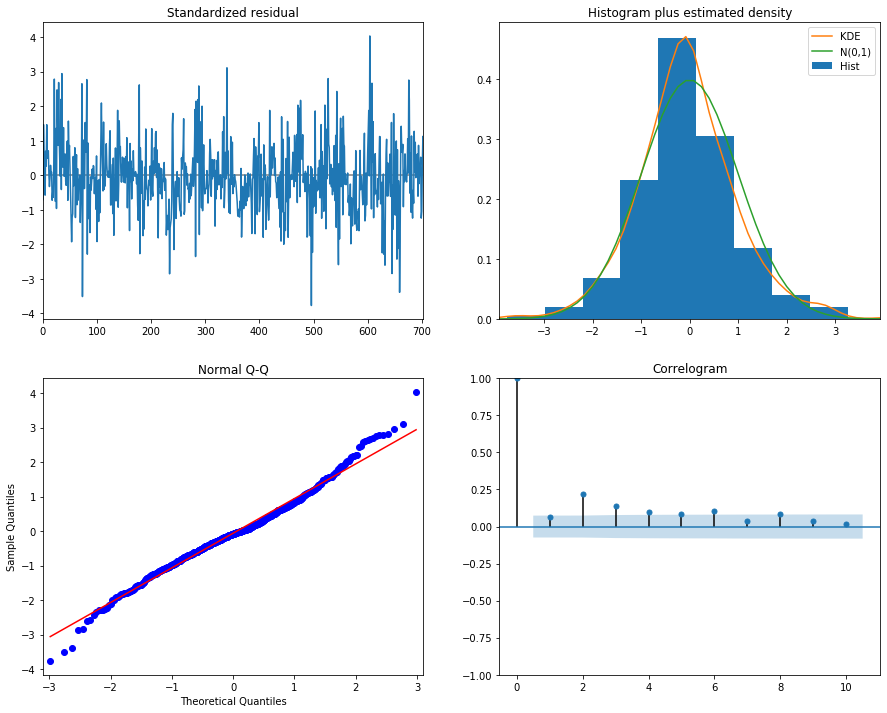

In [34]:
results_opt_w.plot_diagnostics(figsize=(15, 12))
plt.show()

In [35]:
nforecast = N2

pred_opt_w = results_opt_w.forecast(nforecast)
pred_opt_w

array([38104.68703278, 39534.87754339, 37098.81832497, 35393.37757563])

In [36]:
data_w['PJME_MW'].values[-N2:]

array([36420.03571429, 35612.0952381 , 36581.82142857, 36568.80412371])

In [37]:
from sklearn.metrics import mean_absolute_error

In [39]:
er_a = mean_absolute_error(y_true = data_w['PJME_MW'].values[-N2:], y_pred=pred_opt_w) 

print('ошибка mae  :  ', er_a)

ошибка mae  :   1824.9642670696849


In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
er_g = mean_absolute_percentage_error(y_true = data_w['PJME_MW'].values[-N2:],
                                      y_pred = pred_opt_w)

print('ошибка MAPE :  ', er_g,'%')

ошибка MAPE :   5.067118800585285 %


## Задание № 3

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [47]:
er_g = mean_absolute_percentage_error(y_true = data_w['PJME_MW'].values[-N2:-(N2-1)],
                                      y_pred = pred_opt_w[0])

print('ошибка MAPE :  ', er_g,'%')

ошибка MAPE :   4.6256168766949655 %


## Задание № 4

Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [57]:
dt = data_w['PJME_MW'].values[0:-4].copy()
len(dt)

862

In [61]:
for i in range(0, 4):
    mod_tm = sm.tsa.statespace.SARIMAX(dt,
                                      order=[0,0,1],
                                      seasonal_order=[0,1,2,52],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results_opt_tm = mod_tm.fit()
    n_val = results_opt_tm.forecast(1)
    dt = np.append(dt, n_val)
    print(len(dt))

863
864
865
866


In [62]:
dt[-4:]

array([38104.68703278, 39534.63148483, 37099.15832662, 35393.20517019])

In [63]:
er_a_rg = mean_absolute_error(y_true = data_w['PJME_MW'].values[-N2:], y_pred = dt[-4:]) 

print('ошибка mae  :  ', er_a_rg)

ошибка mae  :   1825.030854201441


In [64]:
er_g_rg = mean_absolute_percentage_error(y_true = data_w['PJME_MW'].values[-N2:],
                                      y_pred = dt[-4:])

print('ошибка MAPE :  ', er_g_rg,'%')

ошибка MAPE :   5.067296286049401 %


## Задание № 5

Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

In [73]:
data_d = data.copy().resample('D').mean()

In [74]:
first_diff_l =np.log(data_d.iloc[1:,0].values) 
#first_diff_l, lmbda1 = scs.boxcox(data_d.iloc[1:,0].values) # НЕ РАБОТАЕТ , Т.К. АРГУМЕНТ ЛОГАРИФМА БЛИЗОК 0 
data_d['diff1_l'] = 0
data_d['diff1_l'] =  data_d['diff1_l'].astype('float') 
data_d['diff1_l'].values[1:] = first_diff_l

In [75]:
data_d['d_w7']=data_d['PJME_MW'].rolling(window=7).mean()

In [81]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [82]:
data_d['exp_0_07'] = exponential_smoothing(data_d['PJME_MW'], 0.07)
data_d['exp_0_08'] = exponential_smoothing(data_d['PJME_MW'], 0.08)

In [84]:
column_names = ['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_07', 'exp_0_08']
column_names

['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_07', 'exp_0_08']

In [107]:
X_new = data_d[column_names]
X_new = X_new.loc['2002-01-07':]
X_new.head()

,PJME_MW,diff1_l,d_w7,exp_0_07,exp_0_08
Date,,,,,
2002-01-07,33333.833333,10.414328,32518.879400,31631.175093,31687.998735
2002-01-08,34362.916667,10.444733,32987.761905,31822.397003,31901.992170
2002-01-09,33776.166667,10.427511,32918.422619,31959.160880,32051.926129
2002-01-10,31471.541667,10.356839,32484.089286,31925.027535,32005.495372
2002-01-11,30947.541667,10.340049,32088.672619,31856.603524,31920.859076


In [83]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6059 entries, 2002-01-01 to 2018-08-03
Freq: D
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PJME_MW          6059 non-null   float64
 1   year             6059 non-null   float64
 2   month            6059 non-null   float64
 3   dayofmonth       6059 non-null   float64
 4   quarter          6059 non-null   float64
 5   dayofyear        6059 non-null   float64
 6   weekofyear       6059 non-null   float64
 7   dayofweek        6059 non-null   float64
 8   hour             6059 non-null   float64
 9   is_holiday       6059 non-null   float64
 10  is_prev_holiday  6059 non-null   float64
 11  is_next_holiday  6059 non-null   float64
 12  diff1_l          6059 non-null   float64
 13  d_w7             6053 non-null   float64
 14  exp_0_07         6059 non-null   float64
 15  exp_0_08         6059 non-null   float64
dtypes: float64(16)
memory usage: 964.7

In [108]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

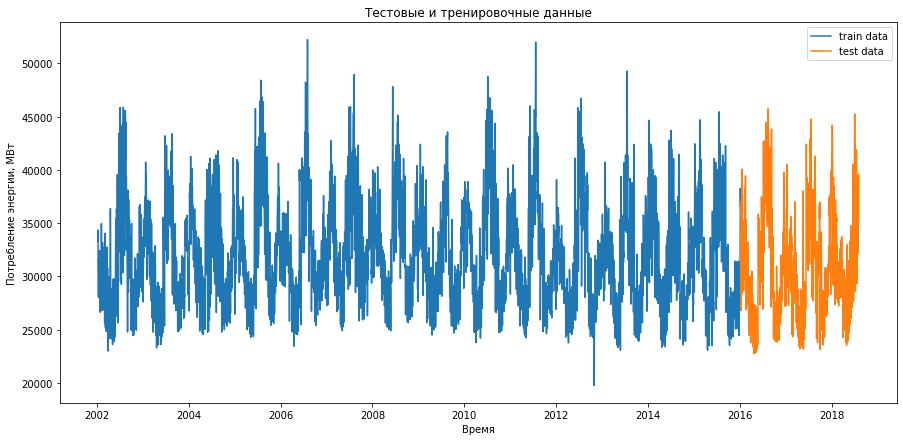

In [109]:
train, test = split_data( X_new, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [117]:
X_train =X_new.iloc[:train.shape[0],:]
y_train =X_new.iloc[:train.shape[0],0]
X_test = X_new.iloc[train.shape[0]:,:]
y_test = X_new.iloc[train.shape[0]:,0]

In [118]:
from sklearn.ensemble import GradientBoostingRegressor

In [122]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=1200)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=y_test ,y_pred = y_test_pred_g)
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   0.06604134417346547 %


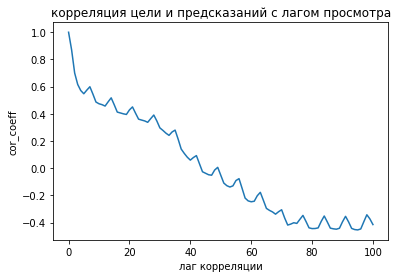

In [123]:
lag=100
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

In [124]:
X_test_100 = X_test.copy()
X_test_100.head()

,PJME_MW,diff1_l,d_w7,exp_0_07,exp_0_08
Date,,,,,
2016-01-07,34061.416667,10.435921,32753.011905,30226.001674,30457.702047
2016-01-08,32150.083333,10.378170,33353.315476,30360.687390,30593.092550
2016-01-09,28611.291667,10.261557,33295.214286,30238.229689,30434.548479
2016-01-10,26807.958333,10.196454,32965.380952,29998.110694,30144.421268
2016-01-11,33504.083333,10.419423,32864.702381,30243.528779,30413.194233


In [129]:
X_test_100.iloc[i,0]

36147.791666666664

In [128]:
X_test_100.shape[1]

5

In [151]:
y_test_100 = y_test.copy()
y_test_100

Date
2016-01-07    34061.416667
2016-01-08    32150.083333
2016-01-09    28611.291667
2016-01-10    26807.958333
2016-01-11    33504.083333
                  ...     
2018-07-30    32957.416667
2018-07-31    34539.083333
2018-08-01    39230.791667
2018-08-02    39593.041667
2018-08-03    35486.000000
Freq: D, Name: PJME_MW, Length: 940, dtype: float64

In [149]:
X_test_100.iloc[[0]]

,PJME_MW,diff1_l,d_w7,exp_0_07,exp_0_08
Date,,,,,
2016-01-07,34061.416667,10.435921,32753.011905,30226.001674,30457.702047


In [154]:
X_test_100.iloc[14+1,0]

37789.291666666664

In [161]:
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
p = 14
N10 = 100
for i in range(p,N10+p):
    y_test_100[i] = model_g_best.predict(X_test_100.iloc[[i]])
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100.iloc[i+1,0] = y_test_100[i:i+1].values
    #строим 'exp_0_07', 'exp_0_08'
    X_test_100.iloc[i+1,4] = X_test_100.iloc[i,4]*(1-0.08)+ 0.08 * X_test_100.iloc[i+1,0] 
    X_test_100.iloc[i+1,3] = X_test_100.iloc[i,3]*(1-0.07)+ 0.07 * X_test_100.iloc[i+1,0] 
    #строим 'd_w7' - признак под номером 3
    X_test_100.iloc[i+1,2] = np.mean(X_test_100.iloc[i-6:i+1,0]) 
    #строим 'diff1_l' - признак под номером 4
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    #устанавливаем новое значение для 4
    X_test_100.iloc[i+1,1] = np.log(y_test_100[i:i+1].values) 
   

In [ ]:
# ещё не доделал модель